<a href="https://colab.research.google.com/github/curyumafu/sakana/blob/main/%E7%94%BB%E5%83%8F%E5%88%86%E9%A1%9EInceptionResNetV2(2023).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

セル１：GoogleDriveのマウントとディレクトリの変更

In [ ]:
from google.colab import drive

# Google Drive をマウント
drive.mount('/content/drive')

# 作業ディレクトリを変更
%cd /content/drive/MyDrive/実験III_AI演習（ImageNet）2023


Mounted at /content/drive
/content/drive/MyDrive/実験III_AI演習（ImageNet）2023


セル2：必要なライブラリのインポート

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from keras.models import Sequential, load_model
from keras.layers import Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import pickle
import shutil


セル3：データセットの準備とクラス情報の取得

In [ ]:
# パス設定
path = "./dataset"
path_save = "./savedata"

# ディレクトリからクラスを取得
folders = os.listdir(path)
classes = [f for f in folders if os.path.isdir(os.path.join(path, f))]
n_classes = len(classes)

# クラスラベルを表示
for i, class_label in enumerate(classes):
    print(f"Class {i}: {class_label}")

Class 0: ウナギ
Class 1: サンフィッシュ
Class 2: サケ
Class 3: ナマズ
Class 4: コイ
Class 5: カジカ
Class 6: 背景
Class 7: ドジョウ
Class 8: アユ
Class 9: アカザ
Class 10: ハゼ


セル4：データジェネレータの設定

In [ ]:
# データジェネレータの設定
batch_size = 8
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #rotation_range=20,  # ランダムな回転
    #width_shift_range=0.1,  # ランダムな水平シフト
    #height_shift_range=0.1,  # ランダムな垂直シフト
    #shear_range=10,  # シアー変換
    #zoom_range=0.1,  # ランダムなズーム
    #horizontal_flip=True,  # 水平方向へのランダムなフリップ
    #vertical_flip=True,  # 垂直方向へのランダムなフリップ
    validation_split=0.2  # 検証データの割合
)


セル5：データジェネレータのインスタンス化

In [ ]:
# 訓練データと検証データのジェネレータを作成
train_generator = train_datagen.flow_from_directory(
    path, target_size=(299, 299), batch_size=batch_size,
    class_mode='categorical', save_to_dir=path_save, save_format='jpeg',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    path, target_size=(299, 299), batch_size=batch_size,
    class_mode='categorical', subset='validation'
)
# クラスラベルとインデックスの辞書を取得
class_indices = train_generator.class_indices

# インデックスに基づいてクラスラベルのリストを生成
classes = [k for k, v in sorted(class_indices.items(), key=lambda item: item[1])]

# クラスラベルのリストを表示
for i, class_label in enumerate(classes):
    print(f"Class {i}: {class_label}")


Found 418 images belonging to 11 classes.
Found 101 images belonging to 11 classes.
Class 0: アカザ
Class 1: アユ
Class 2: ウナギ
Class 3: カジカ
Class 4: コイ
Class 5: サケ
Class 6: サンフィッシュ
Class 7: ドジョウ
Class 8: ナマズ
Class 9: ハゼ
Class 10: 背景


セル6：モデルの構築とコンパイル

In [ ]:
# モデルの構築
input_tensor = Input(shape=(299, 299, 3))
base_model = InceptionResNetV2(weights='imagenet', input_tensor=input_tensor, include_top=False)
n_layers_base_model = len(base_model.layers)

# ベースモデルの層を凍結
base_model.trainable = False

# モデルの構築
model = Sequential()
model.add(base_model)
model.add(Flatten())  # 一次元の配列に変換
model.add(Dense(n_classes, activation='softmax'))

# モデルのコンパイル
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

# モデルの概要の表示
print(model.summary())



219055592/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 8, 8, 1536)        54336736  
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 98304)             0         
                                                                 
 dense (Dense)               (None, 11)                1081355   
                                                                 
Total params: 55418091 (211.40 MB)
Trainable params: 1081355 (4.13 MB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________
None


セル7：モデルの訓練

In [ ]:
# モデルの訓練
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)


<ipython-input-7-b3842444cfdd>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
52/52 [==============================] - 336s 6s/step - loss: 1.6145 - accuracy: 0.5951 - val_loss: 0.7885 - val_accuracy: 0.6979
Epoch 2/10
52/52 [==============================] - 284s 5s/step - loss: 0.3948 - accuracy: 0.9049 - val_loss: 0.9653 - val_accuracy: 0.8021
Epoch 3/10
52/52 [==============================] - 316s 6s/step - loss: 0.5159 - accuracy: 0.9341 - val_loss: 0.7053 - val_accuracy: 0.7917
Epoch 4/10
52/52 [==============================] - 321s 6s/step - loss: 0.6281 - accuracy: 0.9195 - val_loss: 0.7067 - val_accuracy: 0.8021
Epoch 5/10
52/52 [==============================] - 319s 6s/step - loss: 0.4611 - accuracy: 0.9366 - val_loss: 0.7863 - val_accuracy: 0.8021
Epoch 6/10
52/52 [==============================] - 317s 6s/step - loss: 0.4355 - accuracy: 0.9244 - val_loss: 0.6846 - val_accuracy: 0.8021
Epoch 7/10
52/52 [==============================] - 317s 6s/step - loss: 0.5421 - accuracy: 0.9244 - val_loss: 0.8593 - val_accuracy: 0.8125
Epoch 8/10
52

セル8：訓練結果の表示

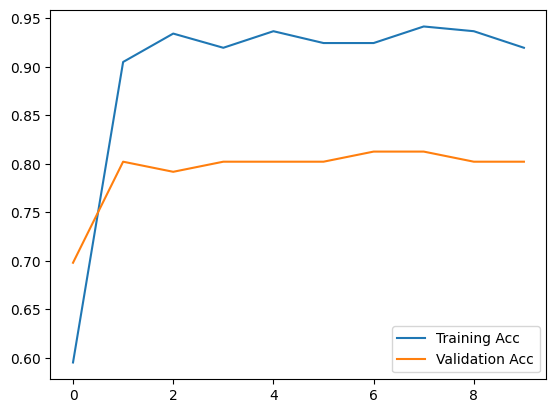

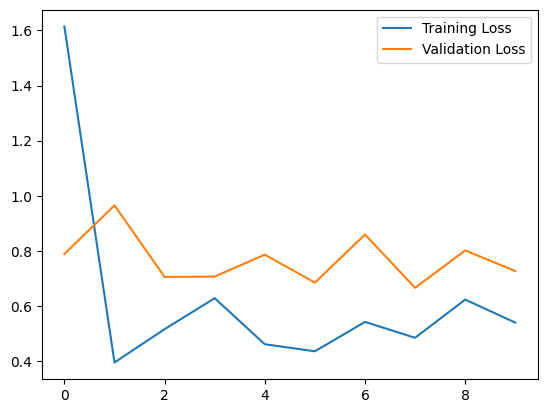

In [ ]:
# 訓練の履歴をプロット
plt.figure()
plt.plot(history.history["accuracy"], label="Training Acc")
plt.plot(history.history["val_accuracy"], label="Validation Acc")
plt.legend()

plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


In [ ]:
# クラスラベルのリストを表示
for i, class_label in enumerate(classes):
    print(f"Class {i}: {class_label}")

Class 0: アカザ
Class 1: アユ
Class 2: ウナギ
Class 3: カジカ
Class 4: コイ
Class 5: サケ
Class 6: サンフィッシュ
Class 7: ドジョウ
Class 8: ナマズ
Class 9: ハゼ
Class 10: 背景


セル9：モデルとクラス情報の保存

In [ ]:
# クラス情報とモデルを保存
pickle.dump(classes, open('./classes.sav', 'wb'))
model.save('./cnn_saved_model')

# 保存した画像を削除
shutil.rmtree(path_save)
os.mkdir(path_save)
# クラスラベルとインデックスの辞書を取得
class_indices = train_generator.class_indices


NameError: ignored

セル10：モデルとクラス情報の読み込み

In [ ]:
# 保存したモデルとクラス情報を読み込む
import tensorflow as tf
# SavedModel 形式でモデルを読み込む
model = tf.keras.models.load_model('./cnn_saved_model')
classes = pickle.load(open('./classes.sav', 'rb'))
for i, class_label in enumerate(classes):
    print(f"Class {i}: {class_label}")

セル11：画像の読み込みと前処理（1枚目）

In [ ]:
# 1枚目の画像を読み込み、前処理を行う
img = cv2.imread('back.jpg')
img = cv2.resize(img, dsize=(299, 299))
img = np.array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)


セル12：モデルによる予測と結果の表示（1枚目）

In [ ]:
# 1枚目の画像に対する予測を行い、結果を表示する
result = model.predict(img)
np.set_printoptions(precision=3, suppress=True)
print(result * 100)  # 結果をパーセント表示
pred = result.argmax()
print(f"Predicted class: {classes[pred]}")


セル13：画像の読み込みと前処理（2枚目）

In [ ]:
# 2枚目の画像を読み込み、前処理を行う
img = cv2.imread('stick.jpg')
img = cv2.resize(img, dsize=(299, 299))
img = np.array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)



セル14：モデルによる予測と結果の表示（2枚目）

In [ ]:
# 2枚目の画像に対する予測を行い、結果を表示する
result = model.predict(img)
np.set_printoptions(precision=3, suppress=True)
print(result * 100)  # 結果をパーセント表示
pred = result.argmax()
print(f"Predicted class: {classes[pred]}")
